<a href="https://colab.research.google.com/gist/danmacode/ddfb2cb3efc7d1e2da621b16786a1f3f/fcc_cat_dog.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [91]:
try:
  # This command only in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator


import os
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [ ]:
# Get project files

# https://stackoverflow.com/questions/4944295/skip-download-if-files-already-exist-in-wget
!wget -N "https://cdn.freecodecamp.org/project-data/cats-and-dogs/cats_and_dogs.zip"

!unzip -nq "cats_and_dogs.zip" # don't overwrite; quietly

PATH = Path("cats_and_dogs")

train_dir = PATH / "train"
validation_dir = PATH / "validation"
test_dir = os.path.join(PATH, "test")

# Get number of files in each directory. The train and validation directories
# each have the subdirecories "dogs" and "cats".
total_train = sum([len(files) for r, d, files in os.walk(train_dir)])
total_val = sum([len(files) for r, d, files in os.walk(validation_dir)])
total_test = len(os.listdir(test_dir))

# Variables for pre-processing and training.
batch_size = 128
epochs = 15
IMG_HEIGHT = 150
IMG_WIDTH = 150

### Cell 3
Use `ImageDataGenerator` to read / decode the images and convert them into floating point tensors.

Use the `rescale` argument (and no other arguments for now) to rescale the tensors from values between 0 and 255 to values between 0 and 1

For the `*_data_gen variables`, use the flow_from_directory method. Pass in the batch size, directory, target size ((IMG_HEIGHT, IMG_WIDTH)), class mode, and anything else required. test_data_gen will be the trickiest one. For test_data_gen, make sure to pass in `shuffle=False` to the `flow_from_directory` method. This will make sure the final predictions stay is in the order that our test expects. 

For `test_data_gen` it will also be helpful to observe the directory structure.

After you run the code, the output should look like this:
```text
Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 50 images belonging to 1 class.
```

In [93]:
# 3

norm: float = 1.0 / 255

train_image_generator = ImageDataGenerator(rescale=norm)
validation_image_generator = ImageDataGenerator(rescale=norm)
test_image_generator = ImageDataGenerator(rescale=norm)

train_data_gen = train_image_generator.flow_from_directory(
    train_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=batch_size,
    class_mode="binary",
    shuffle=True,
)

val_data_gen = validation_image_generator.flow_from_directory(
    validation_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=batch_size,
    class_mode="binary",
    shuffle=True,
)

# this doesn't shuffle so the predictions stay in the test order
test_data_gen = test_image_generator.flow_from_directory(
    PATH,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=batch_size,
    classes=["test"],
    shuffle=False,
)


Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 50 images belonging to 1 classes.


# Cell 4
The plotImages function will be used a few times to plot images. It takes an array of images and a probabilities list, although the probabilities list is optional. 

This code is given to you. If you created the `train_data_gen` variable correctly, then running this cell will plot **five random training images**.

In [ ]:
# 4
from numpy.core.multiarray import ndarray
from typing import Union

def plotImages(images_arr, probabilities: Union[bool, ndarray] = False):
    if not isinstance(probabilities, ndarray) and not probabilities:
        fig, axes = plt.subplots((1+len(images_arr))//2, 2, figsize=(6,9)) 
        fig.suptitle("Images without probabilities")
        for img, ax in zip(images_arr, [*axes[0], *axes[1], *axes[2]]  ):
            ax.imshow(img)
            ax.axis("off")
        plt.show()
    # linter will complain unless we type check
    elif isinstance(probabilities, ndarray):
        fig, axes = plt.subplots(len(images_arr), 1, figsize=(5,len(images_arr) * 3))
        for img, probability, ax in zip(images_arr, probabilities, axes):
            ax.imshow(img)
            ax.axis("off")
            if probability > 0.5:
                ax.set_title("%.2f" % (probability * 100) + "% dog")
            else:
                ax.set_title(f"{((1-probability)*100):.2f}% cat")
        plt.show()    
    


sample_training_images, _ = next(train_data_gen)
# plot 5 random training images
plotImages(sample_training_images[:6])




In [95]:
# 5
train_image_generator = ImageDataGenerator(
    rescale=1.0 / 255,
    horizontal_flip=True,
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    fill_mode="nearest",
)


In [ ]:
# 6
train_data_gen = train_image_generator.flow_from_directory(
    batch_size=batch_size,
    directory=train_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    class_mode="binary",
)

augmented_images = [train_data_gen[0][0][0] for i in range(6)]

plotImages(augmented_images)


# Cell 7
In this cell, create a model for the neural network that outputs class probabilities. It should use the Keras Sequential model. It will probably involve a stack of Conv2D and MaxPooling2D layers and then a fully connected layer on top that is activated by a ReLU activation function.

Compile the model passing the arguments to set the optimizer and loss. Also pass in `metrics=['accuracy']` to view training and validation accuracy for each training epoch.

In [127]:
# 7
# keras sequential neural network args
INPUT_SHAPE = train_data_gen.image_shape or (IMG_HEIGHT, IMG_WIDTH, 3)
kernel = (3, 3)
pool = (2, 2)
dropout = 0.2

# stack of 2D convolutions & maxpooling2D layers, then Flatten & Dense
# https://stackoverflow.com/questions/43237124/what-is-the-role-of-flatten-in-keras
model = Sequential(
    [
        Conv2D(16, kernel, activation="relu", input_shape=INPUT_SHAPE),
        MaxPooling2D(pool),
        Conv2D(32, kernel, activation="relu"),
        MaxPooling2D(pool),
        Conv2D(64, kernel, activation="relu"),
        MaxPooling2D(pool),
        Conv2D(64, kernel, activation="relu"),
        MaxPooling2D(pool),
        Flatten(),
        Dropout(0.2),
        Dense(512, activation="relu"),
        Dense(1, activation="sigmoid"),
    ]
)

# Print a summary of the model
model.summary()

# Compile the model
# show metrics: training & validation accuracy for each training epoch
print("Compiling the model")
model.compile(
    loss="binary_crossentropy",
    optimizer="adam",
    metrics=["accuracy"],  
)


Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_67 (Conv2D)          (None, 148, 148, 16)      448       
                                                                 
 max_pooling2d_67 (MaxPoolin  (None, 74, 74, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_68 (Conv2D)          (None, 72, 72, 32)        4640      
                                                                 
 max_pooling2d_68 (MaxPoolin  (None, 36, 36, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_69 (Conv2D)          (None, 34, 34, 64)        18496     
                                                                 
 max_pooling2d_69 (MaxPoolin  (None, 17, 17, 64)     

# Cell 8
Use the `fit` method on your model to train the network. Make sure to pass in arguments for `x`, `steps_per_epoch`, `epochs`, `validation_data`, and `validation_steps`.

In [129]:
# 8
# There are 15 epochs here - ETA: ~15 min
# create int arguments w/ floor division
spe = total_train // batch_size
val_stp = total_val // batch_size
print(
    "The model has the following parameters:\n"
    f"Epochs: {epochs}\n"
    f"Steps per epoch: {spe}\n"
    f"Validation steps: {val_stp}\n"
)

# Train the network
history = model.fit(
    x=train_data_gen,
    epochs=epochs,
    steps_per_epoch=spe,
    validation_data=val_data_gen,
    validation_steps=val_stp,
    verbose=1,
)



Epochs: 15
Steps per epoch: 15
Validation steps: 7

Epoch 1/15
15/15 [==============================] - 94s 6s/step - loss: 0.6869 - accuracy: 0.5326 - val_loss: 0.6738 - val_accuracy: 0.5815
Epoch 2/15
15/15 [==============================] - 91s 6s/step - loss: 0.6742 - accuracy: 0.5802 - val_loss: 0.6584 - val_accuracy: 0.6038
Epoch 3/15
15/15 [==============================] - 106s 7s/step - loss: 0.6737 - accuracy: 0.5732 - val_loss: 0.6604 - val_accuracy: 0.5536
Epoch 4/15
15/15 [==============================] - 80s 5s/step - loss: 0.6690 - accuracy: 0.5737 - val_loss: 0.6320 - val_accuracy: 0.6473
Epoch 5/15
15/15 [==============================] - 79s 5s/step - loss: 0.6541 - accuracy: 0.5946 - val_loss: 0.6462 - val_accuracy: 0.6708
Epoch 6/15
15/15 [==============================] - 89s 6s/step - loss: 0.6419 - accuracy: 0.6303 - val_loss: 0.6661 - val_accuracy: 0.5547
Epoch 7/15
15/15 [==============================] - 89s 6s/step - loss: 0.6235 - accuracy: 0.6384 - val_los

# Cell 9
Run this cell to visualize the accuracy and loss of the model.

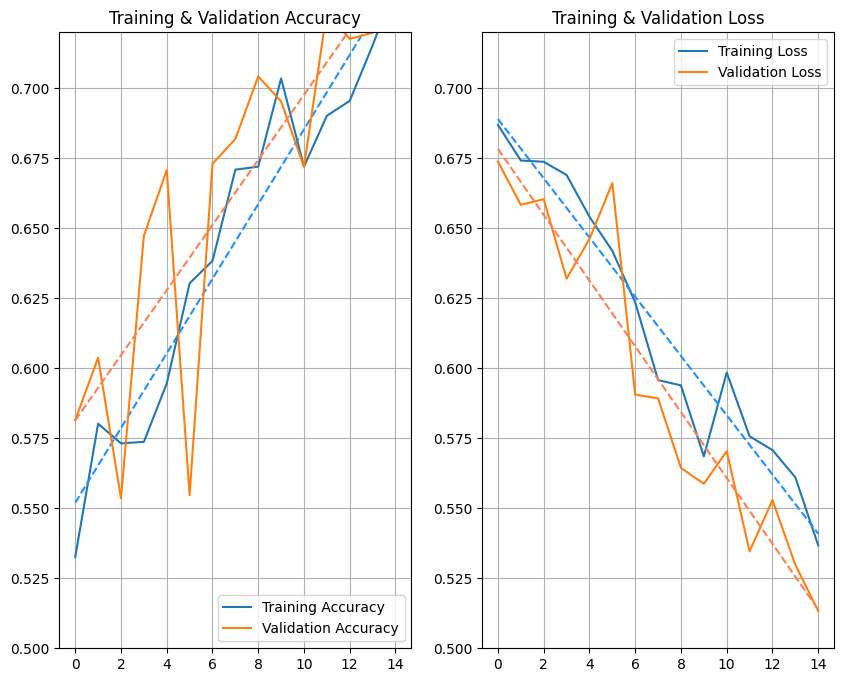

In [145]:
# 9
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]

loss = history.history["loss"]
val_loss = history.history["val_loss"]

epochs_range = range(epochs)

plt.figure(figsize=(10, 8))

# accuracy plot
plt.subplot(1, 2, 1)
plt.title("Training & Validation Accuracy")
plt.plot(epochs_range, acc, label="Training Accuracy")
m, b = np.polyfit(epochs_range, acc, 1)
plt.plot(epochs_range, m*epochs_range+b, "--", color="dodgerblue")
plt.plot(epochs_range, val_acc, label="Validation Accuracy")
m, b = np.polyfit(epochs_range, val_acc, 1)
plt.plot(epochs_range, m*epochs_range+b, "--", color="coral")
plt.legend(loc="lower right")
plt.grid()
plt.ylim([0.50, 0.72])

# loss plot
plt.subplot(1, 2, 2)
plt.title("Training & Validation Loss")
plt.plot(epochs_range, loss, label="Training Loss")
m, b = np.polyfit(epochs_range, loss, 1)
plt.plot(epochs_range, m*epochs_range+b, "--", color="dodgerblue")
plt.plot(epochs_range, val_loss, label="Validation Loss")
m, b = np.polyfit(epochs_range, val_loss, 1)
plt.plot(epochs_range, m*epochs_range+b, "--", color="coral")
plt.legend(loc="upper right")
plt.grid()
plt.ylim([0.50, 0.72])
# show plot
plt.show()


# Cell 10
Now it is time to use your model to predict whether a brand new image is a cat or a dog.

In this cell, get the probability that each test image (from `test_data_gen`) is a dog or a cat. probabilities should be a list of integers.

Call the `plotImages` function and pass in the test images and the probabilities corresponding to each test image.

After you run the cell, you should see all 50 test images with a label showing the percentage of "sure" that the image is a cat or a dog. The accuracy will correspond to the accuracy shown in the graph above (after running the previous cell). More training images could lead to a higher accuracy.

In [ ]:
"""
https://stackoverflow.com/questions/52733216/how-to-get-the-probability-percentage-in-keras-predicting-model-cnn
Can predictions scores have negative values? 
https://github.com/tensorflow/ranking/issues/62
"""
#probabilities: ndarray = model.predict(test_data_gen).flatten()
arr_prob = model.predict(test_data_gen)
probabilities = np.array(arr_prob.reshape(-1))
train_images, _ = next(train_data_gen)

print(
    f"There are {len(probabilities)} samples in the probabilities array\n"
    f"There are {len(train_images)} images in the test_images array"
)

# Call the plotImages function and pass in the test images & probabilities
# corresponding to each test image.

plotImages(train_images[0:5], probabilities=probabilities)



# Cell 11
Run this final cell to see if you passed the challenge or if you need to keep trying.

In [150]:
# 11
# percent. of correct answers necessary to pass the test
threshold = 63 

answers =  [1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0,
            1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0,
            1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1,
            1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 
            0, 0, 0, 0, 0, 0]

correct = 0

for probability, answer in zip(probabilities, answers):
    if round(probability) == answer:
        correct += 1
percentage_identified = (correct / len(answers)) * 100

passed_challenge: bool = percentage_identified >= threshold

print(
    f"Your model correctly identified {int(round(percentage_identified, 2))}% "
    "of the images of cats and dogs."
)

if passed_challenge:
    print("You passed the challenge!")
else:
    print(
        "You haven't passed yet. "
        f"Your model should identify at least {threshold}% of the images. "
        "Keep trying. You will get it!"
    )


Your model correctly identified 72% of the images of cats and dogs.
You passed the challenge!
